In [93]:
!pip install git+https://github.com/GerbenBeintema/deepSI@master

  Cloning https://github.com/GerbenBeintema/deepSI (to revision master) to /tmp/pip-req-build-p5qk776t
  Running command git clone --filter=blob:none --quiet https://github.com/GerbenBeintema/deepSI /tmp/pip-req-build-p5qk776t
  Resolved https://github.com/GerbenBeintema/deepSI to commit 28c96c174fa2e1c83aeb26091d67785d468a4bee
  Preparing metadata (setup.py) ... done


In [94]:
archive_path = 'ffmpeg-master-latest-linux64-gpl.tar.xz'
output_dir = 'ffmpeg/'  # You can use an existing or new directory

# Extract the archive
!tar -xf {archive_path} -C {output_dir}

In [95]:
import os

# Example directory containing the FFmpeg binaries
ffmpeg_dir = 'ffmpeg/ffmpeg-master-latest-linux64-gpl/bin'

# Add the FFmpeg directory to the PATH environment variable
os.environ['PATH'] = ffmpeg_dir + os.pathsep + os.environ['PATH']

In [96]:
#import sys
#sys.path.insert(0, '/gpfs/scratch1/nodespecific/gcn3/klaemers.6208466/pip-req-build-cdv8bmd8')
import deepSI
from tqdm import tqdm
import numpy as np
import cv2
from deepSI import System_data
from matplotlib import pyplot as plt
linewidth = 3.320
reducesize = 1
fig_fontsize = (10*19/28)*reducesize
plt.rcParams.update({'font.size': fig_fontsize})
dpi = 200
pad = 0.4

In [97]:
# Load the npz file
adi = 12
systemsdir = 'systems/'
filen = 'combined_output_20_3.npz'
data = np.load(filen, allow_pickle=True)

# Assuming you have arrays 'frames' and 'forces' within your npz file
frames = data['frames']
forces = data['forces']

# Determine the size of each set
total_size = len(frames)
train_size = int(total_size * 0.6)  # 50% of the data for training
val_size = int(total_size * 0.20)  # 20% of the data for validation
test_size = total_size - train_size - val_size  # Remaining 30% for testing

# Function to resize and reshape frames with progress bar
def resize_and_reshape_frames(frames, batch_size, new_height, new_width):
    num_frames = frames.shape[0]
    resized_and_reshaped_frames = np.zeros((num_frames, frames.shape[3], new_height, new_width), dtype=np.uint8)
    for start in tqdm(range(0, num_frames, batch_size), desc="Resizing frames"):
        end = start + batch_size
        batch_frames = frames[start:end]
        for i in range(batch_frames.shape[0]):
            resized_frame = cv2.resize(batch_frames[i], (new_width, new_height), interpolation=cv2.INTER_LINEAR)
            resized_and_reshaped_frames[start + i] = resized_frame.transpose(2, 0, 1)
    return resized_and_reshaped_frames

# Resize and reshape parameters
new_height = frames.shape[1] // 2
new_width = frames.shape[2] // 2
batch_size = 30

# Resize and reshape all frames
frames_resized_reshaped = resize_and_reshape_frames(frames, batch_size, new_height, new_width).astype(np.float32)


Resizing frames: 100%|██████████| 400/400 [00:01<00:00, 213.68it/s]


In [98]:
# Check the shape of the resized frames
print("Shape of the resized frames:", frames_resized_reshaped.shape)

Shape of the resized frames: (12000, 3, 135, 240)


In [99]:
# Split the data
del frames
frames_train = frames_resized_reshaped[:train_size]
frames_val = frames_resized_reshaped[train_size:train_size + val_size]
frames_test = frames_resized_reshaped[train_size + val_size:]
n_channels, height, width = frames_train.shape[1], frames_train.shape[2], frames_train.shape[3]


In [100]:
forces_train = forces[:train_size, 2]
forces_val = forces[train_size:train_size + val_size, 2]
forces_test = forces[train_size + val_size:, 2]
del forces

In [101]:
# Initialize the SS_encoder_CNN_video system
#sys_vbss = deepSI.fit_systems.SS_encoder_CNN_video(na=adi, nb=adi)
n_channels, height, width = frames_train.shape[1], frames_train.shape[2], frames_train.shape[3]
#sys_vbss.init_nets(nu=1, ny=(n_channels, height, width))

In [102]:
# Create System_data instances with resized and reshaped frames
system_data = System_data(u=forces_train, y=frames_train)
system_data_val = System_data(u=forces_val, y=frames_val)
system_data_test = System_data(u=forces_test, y=frames_test)
del forces_train, frames_train, forces_val, frames_val, forces_test, frames_test

In [103]:
# ##Customize normalization for training, validation, and test sets
# sys_vbss.use_norm = False  # Disable automatic normalization

# ##Normalize the frames by computing mean and standard deviation over samples, height, and width
# sys_vbss.norm.y0 = np.mean(system_data.y, axis=(0, 2, 3))[:, None, None]
# sys_vbss.norm.ystd = np.std(system_data.y, axis=(0, 2, 3))[:, None, None]

# ##Normalize forces by computing mean and standard deviation over samples
# sys_vbss.norm.u0 = np.mean(system_data.u, axis=0)
# sys_vbss.norm.ustd = np.std(system_data.u, axis=0)

In [104]:
# Fit the model
#sys_vbss.fit(system_data, val_sys_data=system_data_val, cuda=True, epochs=round(1500/(2*adi)), batch_size=64, loss_kwargs={'online_construct': True})
#sys_vbss.checkpoint_load_system('model2_best')
print(n_channels)

3


In [ ]:
def get_base_results(load=True, timeout=10000,n_channels=n_channels, height=height, width=width):
    train, val, test = system_data, system_data_val, system_data_test
    print(train)
    if load:
        sys_vbss_s = deepSI.load_system(systemsdir+'sse-cnn-base-last')
        sys_vbss_s._dt = None
        sys_vbss_s.feedthrough=False
        sys_vbss_s.norm.y0 = np.mean(train.y, axis=(0, 2, 3))[:, None, None]
        sys_vbss_s.norm.ystd = np.std(train.y, axis=(0, 2, 3))[:, None, None]
        ##Normalize forces by computing mean and standard deviation over samples
        sys_vbss_s.norm.u0 = np.mean(train.u, axis=0)
        sys_vbss_s.norm.ustd = np.std(train.u, axis=0)
        print(sys_vbss_s.norm)
        sys_vbss_best = deepSI.load_system(systemsdir+'sse-cnn-base-best')
        sys_vbss_best._dt = None
        sys_vbss_best.feedthrough=False
        sys_vbss_t = sys_vbss_best.apply_experiment(test).NRMS(test)
    else:
        sys_vbss_s = deepSI.fit_systems.SS_encoder_CNN_video(nx=8, na=adi, nb=adi)
        ##Normalize the frames by computing mean and standard deviation over samples, height, and width
        sys_vbss_s.norm.y0 = np.mean(train.y, axis=(0, 2, 3))[:, None, None]
        sys_vbss_s.norm.ystd = np.std(train.y, axis=(0, 2, 3))[:, None, None]
        ##Normalize forces by computing mean and standard deviation over samples
        sys_vbss_s.norm.u0 = np.mean(train.u, axis=0)
        sys_vbss_s.norm.ustd = np.std(train.u, axis=0)
        print(sys_vbss_s.norm)
        

       # # n_channels, height, width = frames_train.shape[1], frames_train.shape[2], frames_train.shape[3]
        #sys_vbss_s.init_nets(nu=1, ny=(n_channels, height, width))
        sys_vbss_s.fit(system_data, val_sys_data=system_data_val, cuda=True, 
                       epochs=round(1500/(2*adi)), timeout=timeout, 
                       batch_size=128, 
                       validation_measure='sim-NRMS_sys_norm', 
                       loss_kwargs={'online_construct': True, 'nf':5},
                       auto_fit_norm=False,
                       #optimizer_kwargs={'lr':5e-4}
                      )
        sys_vbss_s.save_system('sse-cnn-base-best')
        sys_vbss_t = sys_vbss_s.apply_experiment(test).NRMS(test)
        sys_vbss_s.checkpoint_load_system('_last')
        sys_vbss_s.save_system('sse-cnn-base-last')

    return sys_vbss_s, sys_vbss_t

sys_vbss = get_base_results(load=False)

System_data of length: 7200 nu=None ny=(3, 135, 240) normed=False dt=None
System_data_norm: (u0=-2.81599406957767, ustd=2.198542996611473, y0=[[[179.06047]]

 [[178.54716]]

 [[174.84698]]], ystd=[[[81.04006 ]]

 [[81.9512  ]]

 [[88.001884]]])
Initilizing the model and optimizer
N_training_samples = 7184, batch_size = 128, N_batch_updates_per_epoch = 56
Initial Validation sim-NRMS_sys_norm= 1.001027235283698
Starting indefinite training until 10000 seconds have passed due to provided timeout


0it [00:00, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS_sys_norm = 0.20759811708530346
Epoch    1, sqrt loss  0.5663, Val sim-NRMS_sys_norm 0.2076, Time Loss: 15.0%, data: 49.8%, val: 35.2%,  2.0 sec/batch
########## New lowest validation loss achieved ########### sim-NRMS_sys_norm = 0.1807563546001532
Epoch    2, sqrt loss  0.1915, Val sim-NRMS_sys_norm 0.1808, Time Loss: 14.0%, data: 53.3%, val: 32.7%,  1.8 sec/batch
########## New lowest validation loss achieved ########### sim-NRMS_sys_norm = 0.169621322365673
Epoch    3, sqrt loss   0.175, Val sim-NRMS_sys_norm 0.1696, Time Loss: 14.9%, data: 50.5%, val: 34.6%,  1.6 sec/batch
########## New lowest validation loss achieved ########### sim-NRMS_sys_norm = 0.16412568011146592
Epoch    4, sqrt loss  0.1669, Val sim-NRMS_sys_norm 0.1641, Time Loss: 15.3%, data: 48.6%, val: 36.1%,  1.5 sec/batch
########## New lowest validation loss achieved ########### sim-NRMS_sys_norm = 0.15914128431203278
Epoch    5, sqrt loss  0.1613, V

In [106]:
def get_repro_systems(nxlist, n_repeat=7, load=True, timeout=600):
    train, val, test = system_data, system_data_val, system_data_test
    
    if load:
        return [[deepSI.load_system(systemsdir+f'reprod-enc-{nx}-{i}-last2')  for i in range(n_repeat)] for nx in nxlist]
    
    for nx in nxlist:
        for i in range(n_repeat):
            sys_vbss_s = deepSI.fit_systems.SS_encoder_CNN_video(na=adi, nb=adi, nx=nx)
            sys_vbss_s.norm.y0 = np.mean(train.y, axis=(0, 2, 3))[:, None, None]
            sys_vbss_s.norm.ystd = np.std(train.y, axis=(0, 2, 3))[:, None, None]
            ##Normalize forces by computing mean and standard deviation over samples
            sys_vbss_s.norm.u0 = np.mean(train.u, axis=0)
            sys_vbss_s.norm.ustd = np.std(train.u, axis=0)       
            sys_vbss_s.fit(system_data, val_sys_data=system_data_val, cuda=True, epochs=round(1500/(2*adi)), timeout=timeout, 
                       validation_measure='sim-NRMS_sys_norm', 
                       loss_kwargs={'online_construct': True},
                       batch_size=128, 
                       auto_fit_norm=False,
                       #optimizer_kwargs={'lr':5e-4}
                          )            
            sys_vbss_s.save_system(f'reprod-enc-{nx}-{i}-best2')
            sys_vbss_s.checkpoint_load_system('_last')
            sys_vbss_s.save_system(f'reprod-enc-{nx}-{i}-last2')
            del sys_vbss_s
    return [[deepSI.load_system(systemsdir+f'reprod-enc-{nx}-{i}-last2')  for i in range(n_repeat)] for nx in nxlist]


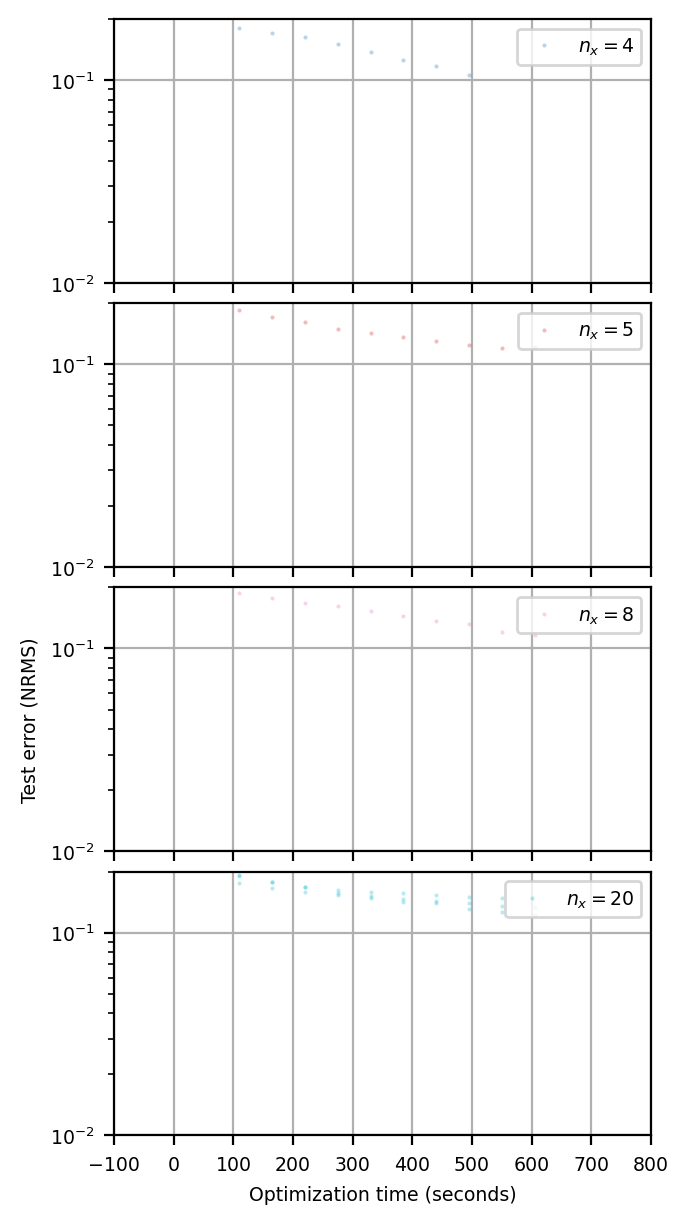

In [107]:
outrepo = get_repro_systems([4,5,8,20],n_repeat=3, load=True, timeout=1600)
from matplotlib import cm
plt.figure(figsize=(linewidth, 1.5 * len(outrepo)), dpi=dpi)  # Adjust the figure height dynamically
cmap = cm.get_cmap('tab10')
for i, outi in enumerate(outrepo):
    col = cmap(i / max(1, len(outrepo) - 1))  # Safeguard division by zero
    ax = plt.subplot(len(outrepo), 1, i + 1)  # Adjust subplot index dynamically

    # Optionally hide x-axis labels except for the last subplot
    if i < len(outrepo) - 1:
        ax.xaxis.set_ticklabels([])

    for k, outij in enumerate(outi):
        plt.semilogy(outij.batch_id, outij.Loss_val, 'o', alpha=0.3, c=col, markersize=0.5,
                     label=f'$n_x={outij.nx}$' if k == 0 else None)
    plt.legend(loc='upper right')
    plt.xlim(-100, 800)
    plt.ylim(0.01, 0.2)
    plt.grid()

    if i == len(outrepo) // 2:  # Center label for the middle plot if multiple
        plt.ylabel('Test error (NRMS)')

plt.xlabel('Optimization time (seconds)')
plt.tight_layout(pad=pad)
plt.savefig('figures/nx-repro.pdf')
plt.savefig('figures/nx-repro.jpg', dpi=600)
plt.show()
del outrepo

In [108]:
def get_nf_systems(nflist,base_epochs=30,load=True,last=True):
    train, val, test = system_data, system_data_val, system_data_test
    
    if load:
        return [deepSI.load_system(systemsdir+f'enc-nf-{nf}-last') for nf in nflist]
    
    for nf in nflist:
        sse_e_s = deepSI.fit_systems.SS_encoder_CNN_video(na=adi, nb=adi, nx=20)
        sse_e_s.norm.y0 = np.mean(train.y, axis=(0, 2, 3))[:, None, None]
        sse_e_s.norm.ystd = np.std(train.y, axis=(0, 2, 3))[:, None, None]
        ##Normalize forces by computing mean and standard deviation over samples
        sse_e_s.norm.u0 = np.mean(train.u, axis=0)
        sse_e_s.norm.ustd = np.std(train.u, axis=0)   
        sse_e_s.fit(system_data, val_sys_data=system_data_val, 
                    cuda=True, 
                    concurrent_val=False, 
                    batch_size=128, 
                    auto_fit_norm=False,
                    validation_measure='sim-NRMS_sys_norm', 
                    loss_kwargs={'online_construct': True, 'nf':nf})
        sse_e_s.save_system(f'enc-nf-{nf}-best')
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system(f'enc-nf-{nf}-last')
    if last:
        return [deepSI.load_system(systemsdir+f'enc-nf-{nf}-last') for nf in nflist]
    else:
        return [deepSI.load_system(systemsdir+f'enc-nf-{nf}-best') for nf in nflist]

## T=nf

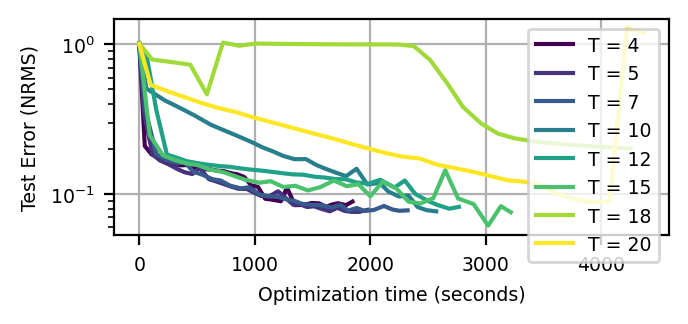

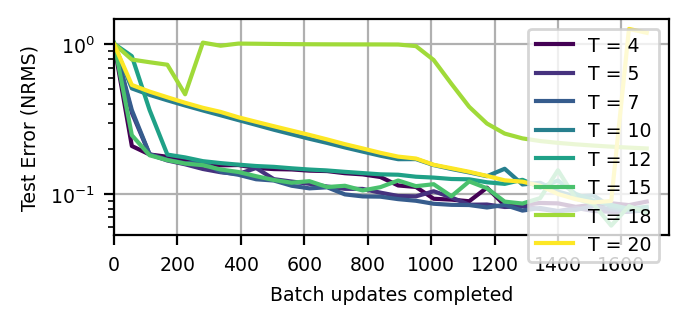

In [109]:
from matplotlib import cm
nflist = [4,5,7,10,12,15,18,20]
outnf = get_nf_systems(nflist,load=True)
# torch.save(outnf,'outnf')


cmap = cm.get_cmap('viridis')

for z,k in enumerate(['time','batch_id']):
    plt.figure(figsize=(linewidth,1.5),dpi=dpi)
    for (i,outi),nf in zip(enumerate(outnf),nflist):
        x = i/(len(outnf)-1)
        time = []
        loss_val = []
        plt.semilogy(outi.__getattribute__(k),outi.Loss_val,c=cmap(x),label='T = '+str(nf))
    plt.ylabel('Test Error (NRMS)')
    if z==0:
        plt.xlabel('Optimization time (seconds)')
    else:
        plt.xlabel('Batch updates completed')
        plt.xlim(0,1750)
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout(pad=pad)
    plt.savefig(f'figures/nf-influ-{k}.pdf')
    plt.show()
del outnf

In [110]:
# test_now = system_data_test
# nflist = [3,4,5,7,10,20,40]
# for last in [True, False]:
#     outnf = get_nf_systems(nflist,load=True,last=last)
#     plt.figure(figsize=(linewidth,1.5),dpi=dpi)
#     for (i,outi),nf in zip(enumerate(outnf),nflist):
#         x = i/(len(outnf))
#         time = []
#         loss_val = []
#         outi._dt = None
#         outi.feedthrough = None
#         n_step_error_now = outi.n_step_error(test_now,nf=10)
#         plt.plot(n_step_error_now,c=cmap(x),label='T = '+str(nf))
#         plt.plot(nf,n_step_error_now[nf],'r.')
#     plt.legend(loc='upper right')
#     plt.grid()
#     plt.xlabel('$k$-steps after initialization')
#     plt.ylabel('Test Error (NRM$S_{k-step}$)')
#     plt.tight_layout(pad=pad)
#     plt.savefig(f'figs/nf-influ-n-step-{"last" if last else "best"}.pdf')
#     plt.show()

# del outnf

In [111]:
def get_na_nb_systems(nalist,load=True,timeout=1200):
    train, val, test = system_data, system_data_val, system_data_test
    
    if load:
        return [deepSI.load_system(systemsdir+f'enc-na-{na}-last') for na in nalist]
    
    for na in nalist:
        sse_e_s = deepSI.fit_systems.SS_encoder_CNN_video(nx=20,na=na,nb=na)
        sse_e_s.norm.y0 = np.mean(train.y, axis=(0, 2, 3))[:, None, None]
        sse_e_s.norm.ystd = np.std(train.y, axis=(0, 2, 3))[:, None, None]
        ##Normalize forces by computing mean and standard deviation over samples
        sse_e_s.norm.u0 = np.mean(train.u, axis=0)
        sse_e_s.norm.ustd = np.std(train.u, axis=0)   
        sse_e_s.fit(system_data, val_sys_data=system_data_val, 
                    cuda=True, 
                    concurrent_val=False, 
                    batch_size=128, 
                    timeout=timeout,
                    auto_fit_norm=False,
                    validation_measure='sim-NRMS_sys_norm', 
                    loss_kwargs={'online_construct': True, 'nf':5})
        sse_e_s.save_system(f'enc-na-{na}-best')
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system(f'enc-na-{na}-last')
    return [deepSI.load_system(systemsdir+f'enc-na-{na}-last') for na in nalist]

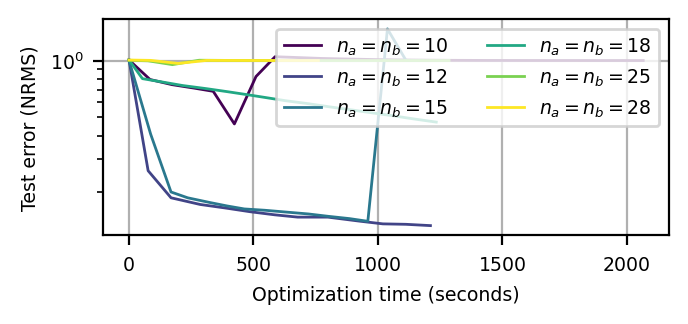

In [112]:
#nalist = [15,18,20,22,25,28,30,32,34,36]
nalist = [10,12,15,18,25,28]
outna = get_na_nb_systems(nalist,load=True)
# torch.save(outna,'outna')

from matplotlib import cm
plt.figure(figsize=(linewidth,1.5),dpi=dpi)
cmap = cm.get_cmap('viridis')
# nalist = [1,2,3,4,5,10,20]


for (i,outi),na in zip(enumerate(outna),nalist):
    x = i/(len(outna)-1)
    time = []
    loss_val = []
    plt.semilogy(outi.time,outi.Loss_val,c=cmap(x),label=f'$n_a = n_b = {str(na)}$',linewidth=1)
plt.ylabel('Test error (NRMS)')
plt.xlabel('Optimization time (seconds)')
plt.legend(loc='upper right',ncol=2)
plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figures/nanb-fig.pdf')
plt.show()
del outna

In [113]:
sys_vbss_s = deepSI.load_system(systemsdir+ f'sse-cnn-base-best')

In [114]:
test_p = sys_vbss_s.apply_experiment(system_data_test)
print(model_t)
# sys_vbss_s.n_step_error_plot(system_data_test, nf=20)

2.0233545


In [115]:
from plot_scripts import strip_plotter

1.1797483e-08 0.07671366 0.041942455


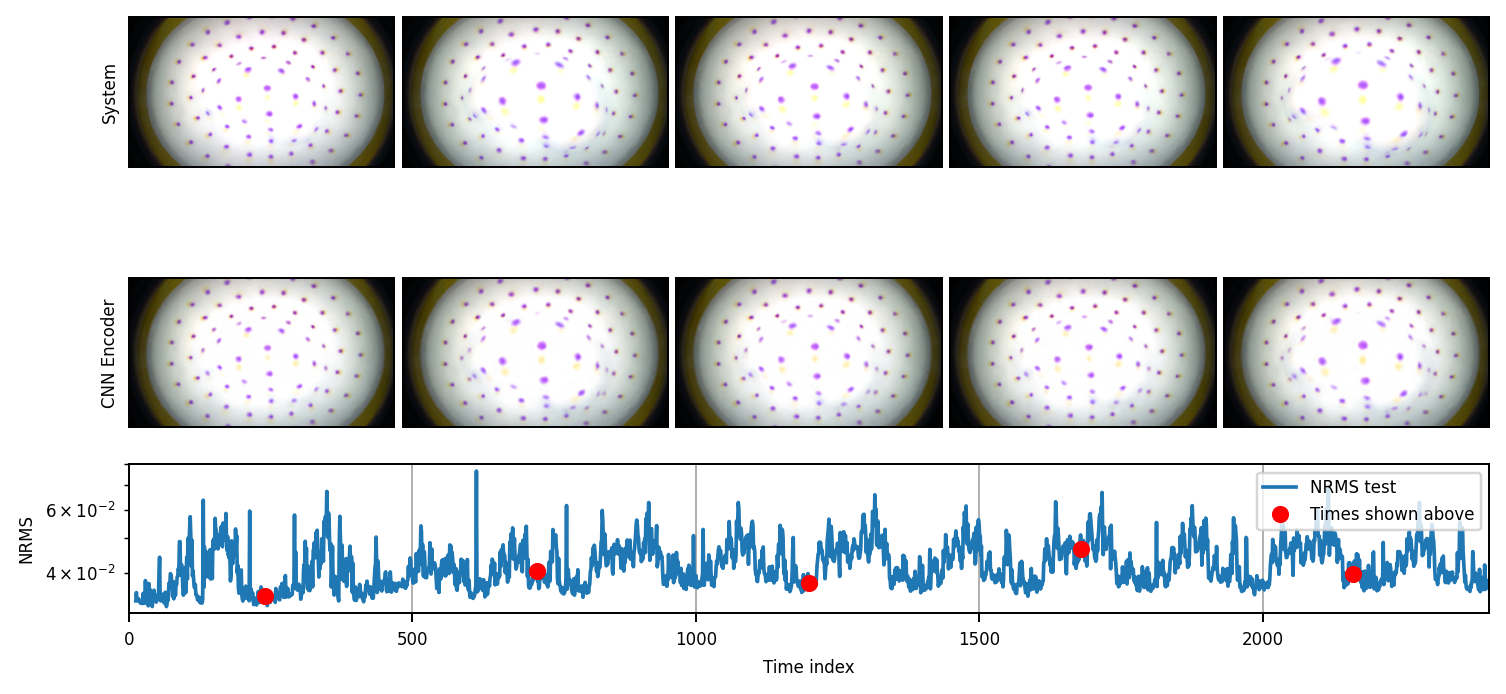

In [127]:
to_img = lambda image: np.transpose(np.clip(np.round(image), 0, 255).astype(np.uint8), (1, 2, 0))
NRMS_time = np.mean(np.mean((system_data_test.y - test_p.y)**2,axis=(2,3))**0.5/sys_vbss_s.norm.ystd[:,0,0],axis=1)
print(min(NRMS_time), max(NRMS_time), np.mean(NRMS_time))
strip_plotter(system_data_test, test_p, sys_vbss_s.norm, to_img=to_img, filename='figures/strip-UD'+str(adi)+'.jpg')

In [117]:
# import pandas as pd
# import os

# # List all files in the directory that match a model file pattern
# model_files = [f for f in os.listdir(systemsdir) if not f.endswith('ipynb_checkpoints')]  # Adjust the pattern as needed

# # Load models with a progress bar
# models = []
# for model_file in tqdm(model_files, desc='Loading models'):
#     models.append(deepSI.load_system(systemsdir + model_file))

# # Run tests and collect NMRs values with a progress bar
# results = []
# for model in tqdm(models, desc='Testing models'):
#     model._dt = None
#     model.feedthrough = False
#     model_t = model.apply_experiment(system_data_test).NRMS(system_data_test)  # Assuming the NRMS method exists and is correctly used

#     results.append({
#         'Model': model,
#         'NRMS': model_t
#     })

# # Create a DataFrame to display results in a table
# results_df = pd.DataFrame(results)

In [118]:
# results_df.to_csv('tests.txt')
# print(results_df)

In [119]:
from plot_scripts import make_video

In [120]:
#!wget https://github.com/BtbN/FFmpeg-Builds/releases/download/latest/ffmpeg-master-latest-linux64-gpl.tar.xz

In [121]:
k = test_p.cheat_n
n = 20
make_video(system_data_test[k:k+30*n],test_p[k:k+30*n],sys_vbss_s.norm, to_img=to_img, target_fps=20, filename='movies/18-test-short'+str(adi)+'.mp4')

  0%|          | 0/600 [00:00<?, ?it/s]